<a href="https://colab.research.google.com/github/alexjercan/depth-estimation/blob/master/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install matplotlib==3.3.3 albumentations==0.5.2

     |████████████████████████████████| 11.6MB 229kB/s 
     |████████████████████████████████| 81kB 8.6MB/s 
     |████████████████████████████████| 37.6MB 79kB/s 
     |████████████████████████████████| 952kB 35.4MB/s 
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [1]:
!git clone https://github.com/alexjercan/depth-estimation.git
%cd depth-estimation

import torch
from IPython.display import clear_output

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.8.1+cu101 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


In [2]:
# Download bdataset
torch.hub.download_url_to_file('https://github.com/alexjercan/depth-estimation/releases/download/v1.0/bdataset_stereo.zip', 'tmp.zip')
!unzip -q tmp.zip -d ../ && rm tmp.zip

In [3]:
!git pull
!python dataset.py
!python model.py

Already up to date.
<Figure size 1000x1000 with 1 Axes>
<Figure size 1000x1000 with 1 Axes>
<Figure size 1000x1000 with 1 Axes>
dataset ok
model ok


In [15]:
import os
import re
import torch
import torch.optim
import albumentations as A
import my_albumentations as M

from datetime import datetime as dt
from config import DEVICE
from model import Model, LossFunction
from general import init_weights, load_checkpoint, save_checkpoint
from dataset import create_dataloader
from metrics import MetricFunction, print_single_error
from detect import generatePredictions
from train import train_one_epoch
from test import run_test
from util import save_predictions, plot_predictions
from dataset import LoadImages
from attr_dict import AttrDict

config_train = AttrDict()

config_train.DATASET_ROOT = "../bdataset_stereo"
config_train.JSON_PATH = "train.json"
config_train.BATCH_SIZE = 8
config_train.IMAGE_SIZE = 256
config_train.WORKERS = 8
config_train.PIN_MEMORY = True
config_train.SHUFFLE = True

config_train.LEARNING_RATE = 0.01
config_train.BETAS = [0.9, 0.999]
config_train.EPS = 0.00000001
config_train.WEIGHT_DECAY = 0.0001

config_train.MILESTONES = [10,20,30]
config_train.GAMMA = 0.2

config_train.NUM_EPOCHS = 40
config_train.TEST = True
config_train.OUT_PATH ="./runs"
config_train.LOAD_MODEL = False
config_train.SAVE_MODEL = False
config_train.CHECKPOINT_FILE = "normal.pth"

config_test = AttrDict()

config_test.DATASET_ROOT = "../bdataset_stereo"
config_test.JSON_PATH = "test.json"
config_test.BATCH_SIZE = 8
config_test.IMAGE_SIZE = 256
config_test.WORKERS = 8
config_test.PIN_MEMORY = True
config_test.SHUFFLE = False

config_test.OUT_PATH = "./runs"
config_test.LOAD_MODEL = True
config_test.CHECKPOINT_FILE = "normal.pth"

config_detect = AttrDict()

config_detect.JSON = [{"imageL": "data/left.png", "imageR": "data/right.png", "output": "data/output.exr"}]
config_detect.IMAGE_SIZE = 256
config_detect.CHECKPOINT_FILE = "normal.pth"

torch.backends.cudnn.benchmark = True

In [6]:
train_transform = A.Compose(
    [
        M.MyRandomResizedCrop(width=config_train.IMAGE_SIZE, height=config_train.IMAGE_SIZE),
        M.MyHorizontalFlip(p=0.5),
        M.MyVerticalFlip(p=0.1),
        A.OneOf([
            A.MotionBlur(p=0.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.OneOf([
            M.MyOpticalDistortion(p=0.3),
            M.MyGridDistortion(p=0.1),
            M.MyIAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        A.OneOf([
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
        M.MyToTensorV2(),
    ],
    additional_targets={
        'right_img': 'image',
        'left_depth': 'depth',
        'right_depth': 'depth',
        'left_normal': 'normal',
        'right_normal': 'normal',
    }
)

test_transform = A.Compose(
    [
        M.MyToTensorV2(),
    ],
    additional_targets={
        'right_img': 'image',
        'left_depth': 'depth',
        'right_depth': 'depth',
        'left_normal': 'normal',
        'right_normal': 'normal',
    }
)

_, train_dataloader = create_dataloader(config_train.DATASET_ROOT, config_train.JSON_PATH, 
                                        batch_size=config_train.BATCH_SIZE, transform=train_transform, 
                                        workers=config_train.WORKERS, pin_memory=config_train.PIN_MEMORY, shuffle=config_train.SHUFFLE)

_, test_dataloader = create_dataloader(config_test.DATASET_ROOT, config_test.JSON_PATH,
                                       batch_size=config_test.BATCH_SIZE, transform=test_transform,
                                       workers=config_test.WORKERS, pin_memory=config_test.PIN_MEMORY, shuffle=config_test.SHUFFLE)

images = LoadImages(config_detect.JSON, img_size=config_detect.IMAGE_SIZE)


In [7]:
model = Model()
model.apply(init_weights)
solver = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                          lr=config_train.LEARNING_RATE, betas=config_train.BETAS, 
                          eps=config_train.EPS, weight_decay=config_train.WEIGHT_DECAY)
# solver = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), 
#                          lr=config.LEARNING_RATE, momentum=0.9,
#                          dampening = 0.1, weight_decay=config.WEIGHT_DECAY)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(solver, milestones=config_train.MILESTONES, gamma=config_train.GAMMA)
model = model.to(DEVICE)
loss_fn = LossFunction()
metric_fn = MetricFunction(config_test.BATCH_SIZE)

epoch_idx = 0
if config_train.CHECKPOINT_FILE and config_train.LOAD_MODEL:
    epoch_idx, model = load_checkpoint(model, config_train.CHECKPOINT_FILE, DEVICE)

In [ ]:
model.train()
for epoch_idx in range(epoch_idx, config_train.NUM_EPOCHS):
    train_one_epoch(model, train_dataloader, loss_fn, solver, epoch_idx)
    lr_scheduler.step()

 30%|██▉       | 8/27 [00:10<00:24,  1.27s/it, epoch=0, loss=(total:0.2823 depth:0.18731892108917236 normal:0.09502296894788742)]

In [9]:
model.eval()
run_test(model, test_dataloader, loss_fn, metric_fn)
print_single_error(1, loss_fn.show(), metric_fn.show())

100%|██████████| 14/14 [00:08<00:00,  1.58it/s]

eval_avg_error
Epoch: 1, loss=(total:0.2779 depth:0.15090462565422058 normal:0.12701115012168884)
======DEPTH=======
MSE=0.0284	RMSE=0.1612	MAE=0.1063	ABS_REL=0.2243
DELTA1.02=0.1008	DELTA1.05=0.3656	DELTA1.10=0.6656
DELTA1.25=0.7553	DELTA1.25^2=0.8698	DELTA1.25^3=0.9466
======NORMALS=======
MSE=0.4808	RMSE=0.6926	MAE=0.6551	MME=0.6493
TANGLE11.25=0.0601	TANGLE22.5=0.0879	TANGLE30.0=0.1023



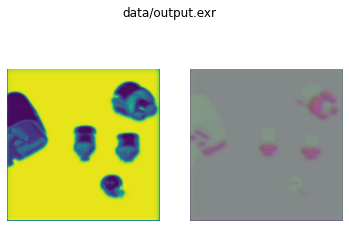

In [13]:
model.eval()
for predictions, path in generatePredictions(model, images):
    plot_predictions(predictions, [path])

In [17]:
output_dir = os.path.join(config_train.OUT_PATH, re.sub("[^0-9a-zA-Z]+", "-", dt.now().isoformat()))

save_checkpoint(epoch_idx, model, output_dir)

print(model)

Model(
  (feature): UNetFeature(
    (down_block1): UNetBlock(
      (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): GroupNorm(8, 16, eps=1e-05, affine=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): GroupNorm(8, 16, eps=1e-05, affine=True)
      (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn3): GroupNorm(8, 16, eps=1e-05, affine=True)
      (max_pool): Identity()
      (relu): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (down_block2): UNetBlock(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): GroupNorm(8, 32, eps=1e-05, affine=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): GroupNorm(8, 32, eps=1e-05, affine=True)
      (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn3): GroupNorm(8, 32, eps=1e-05, affine=True)
     